In [3]:
!pip install tqdm
!pip install scikit-image

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 35.5MB 41kB/s  eta 0:00:01
    100% |################################| 1.6MB 939kB/s eta 0:00:01
    100% |################################| 5.7MB 267kB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
Successfully built networkx
You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
import tensorflow as tf
import utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
map_characters = utils.load_characters()

In [6]:
for k, v in map_characters.items():
    print("{} -> {}".format(k, v))

0 -> abraham_grampa_simpson
1 -> marge_simpson
2 -> bart_simpson
3 -> milhouse_van_houten
4 -> charles_montgomery_burns
5 -> principal_skinner
6 -> krusty_the_clown
7 -> homer_simpson
8 -> chief_wiggum
9 -> sideshow_bob
10 -> lisa_simpson
11 -> moe_szyslak
12 -> ned_flanders


In [7]:
pics, labels = utils.load_pictures(map_characters)

Loading ned_flanders: 100%|██████████| 1454/1454 [00:11<00:00, 121.93it/s]


In [8]:
print("Images shape:")
print(pics.shape)

Images shape:
(16587, 128, 128, 3)


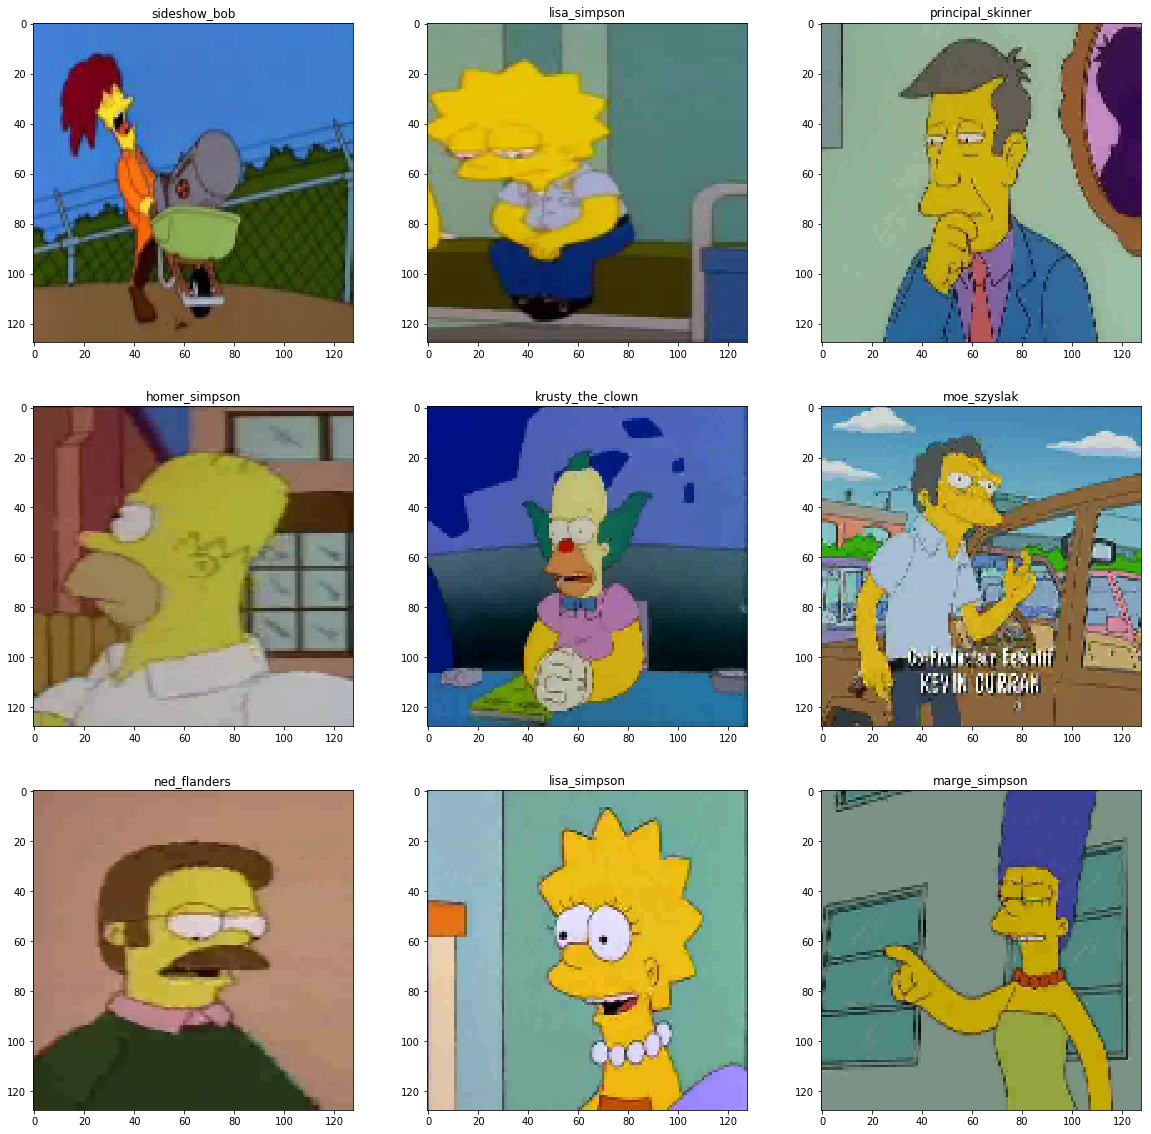

In [9]:
utils.show_random(pics, labels, map_characters)

## Splitting into Train / Validation

In [10]:
pics_train, labels_train, pics_val, labels_val = utils.split(pics, labels, p=0.95)

In [11]:
print("Training data:")
print("X: {}".format(pics_train.shape))
print("Y: {}".format(labels_train.shape))
print()
print("Validation data:")
print("X: {}".format(pics_val.shape))
print("Y: {}".format(labels_val.shape))

Training data:
X: (15757, 128, 128, 3)
Y: (15757, 13)

Validation data:
X: (830, 128, 128, 3)
Y: (830, 13)


## Defining model

In [12]:
H, W, C = pics[0].shape
NUM_CLASSES = len(map_characters)

In [135]:
def load_architecture():
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.uint8, shape=[None, H, W, 3], name="x")
    y = tf.placeholder(tf.uint8, shape=[None, NUM_CLASSES], name="y")
    
    dropout_rate = tf.placeholder_with_default(0.3, shape=(), name="dropout_rate")
    
    is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
    
    init = tf.contrib.layers.xavier_initializer()
    
    out = tf.divide(x, 255)
    
    out = tf.layers.conv2d(out, filters=8, kernel_size=[3,3], activation=tf.nn.relu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
    
#     out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    
    out = tf.layers.conv2d(out, filters=16, kernel_size=[3,3], activation=tf.nn.relu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
    
#     out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    
    out = tf.layers.conv2d(out, filters=32, kernel_size=[3,3], activation=tf.nn.relu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
    
#     out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    
    out = tf.layers.conv2d(out, filters=64, kernel_size=[3,3], activation=tf.nn.relu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
        
    out = tf.contrib.layers.flatten(out)
    
    out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)

    out = tf.layers.dense(out, units=512, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)

    out = tf.layers.dense(out, units=512, activation=tf.nn.relu, kernel_initializer=init)

    out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    
    out = tf.layers.dense(out, units=512, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    
    out = tf.layers.dense(out, units=512, activation=tf.nn.relu, kernel_initializer=init)

    out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    
    out = tf.layers.dense(out, units=NUM_CLASSES, kernel_initializer=init)
    
    return x, y, is_training, dropout_rate, out

In [83]:
def load_loss(y, out):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out, name="mean_loss")
    loss = tf.reduce_mean(loss, name="loss")
    return loss

In [55]:
def load_accuracy(y, out):
    pred = tf.argmax(out, axis=-1)
    gt = tf.argmax(y, axis=-1)
    
    matches = tf.equal(pred, gt)
    
    return tf.reduce_mean(tf.cast(matches, tf.float32), name="acc")

In [16]:
def load_trainer(loss):
    opt = tf.train.AdamOptimizer()
    return opt.minimize(loss)

In [17]:
def register_scalars(m):
    for k, v in m.items():
        tf.summary.scalar(k, v)

In [18]:
def register_images(m):
    for k, v in m.items():
        tf.summary.image(k, v)

In [19]:
def trainable_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    return total_parameters

In [20]:
def load_model():
    x, y, is_training, dropout_rate, out = load_architecture()
    loss = load_loss(y, out)
    acc = load_accuracy(y, out)
    upd = load_trainer(loss)
    
    register_scalars({"info_loss": loss, "info_acc": acc})
    register_images({"input": x})

    info = tf.summary.merge_all()
    
    return x, y, is_training, dropout_rate, out, loss, acc, upd, info

# Train model

In [21]:
def load_session():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    return sess

In [131]:
def train(sess, model, pics_train, labels_train, pics_val, labels_val, epochs, batch_size, train_writer, val_writer, use_dropout=False):
    N, _, _, _ = pics_train.shape
    idxs = np.arange(N)
    
    x, y, is_training, dropout_rate, out, loss, acc, upd, info = model
    
    d_rate = 0.4 if use_dropout else 0.
    
    i=0

    for ep in tqdm(range(epochs)):
        np.random.shuffle(idxs)
        pics_train = pics_train[idxs]
        labels_train = labels_train[idxs]

        for b in range(0, N, batch_size):
            X_batch = pics_train[b:b+batch_size]
            Y_batch = labels_train[b:b+batch_size]

            if X_batch.shape[0] < BATCH_SIZE:
                break

            graph_info, _ = sess.run([info, upd], feed_dict={x: X_batch, y: Y_batch, is_training: True, dropout_rate: d_rate})
            train_writer.add_summary(graph_info, i)
            
            graph_info, = sess.run([info], feed_dict={x: pics_val, y: labels_val, is_training: False, dropout_rate: d_rate})
            val_writer.add_summary(graph_info, i)
            
            i+=1

In [100]:
def predict(imgs, model):
    x, y, is_training, dropout_rate, out, loss, acc, upd, info = model

    N, H, W, _ = imgs.shape
    fig=plt.figure(figsize=(20, 20))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        idx = np.random.choice(range(N)) 
        img = imgs[idx]
        img_batch = np.reshape(img, [1, H, W, 3])
        graph_out, = sess.run([out], feed_dict={x: img_batch})
        char = np.argmax(np.squeeze(graph_out))
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(map_characters[char])
    plt.show()

### Overfitting data first

In [24]:
pics_train_sm, labels_train_sm = utils.get_small_dataset(pics_train, labels_train, p=0.01)

In [25]:
print("New training dataset size: {}".format(pics_train_sm.shape[0]))

New training dataset size: 157


In [26]:
model = load_model()
print("Trainable parameters: {}".format(trainable_parameters()))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Trainable parameters: 8419373


In [27]:
EPOCHS = 20
BATCH_SIZE = 32
LOGS_DIR = "logs"

sess = load_session()

t_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "overfit", "train"), graph=sess.graph)
v_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "overfit", "val"), graph=sess.graph)

train(sess, model, pics_train_sm, labels_train_sm, pics_val, labels_val, EPOCHS, BATCH_SIZE, t_writer, v_writer)

100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


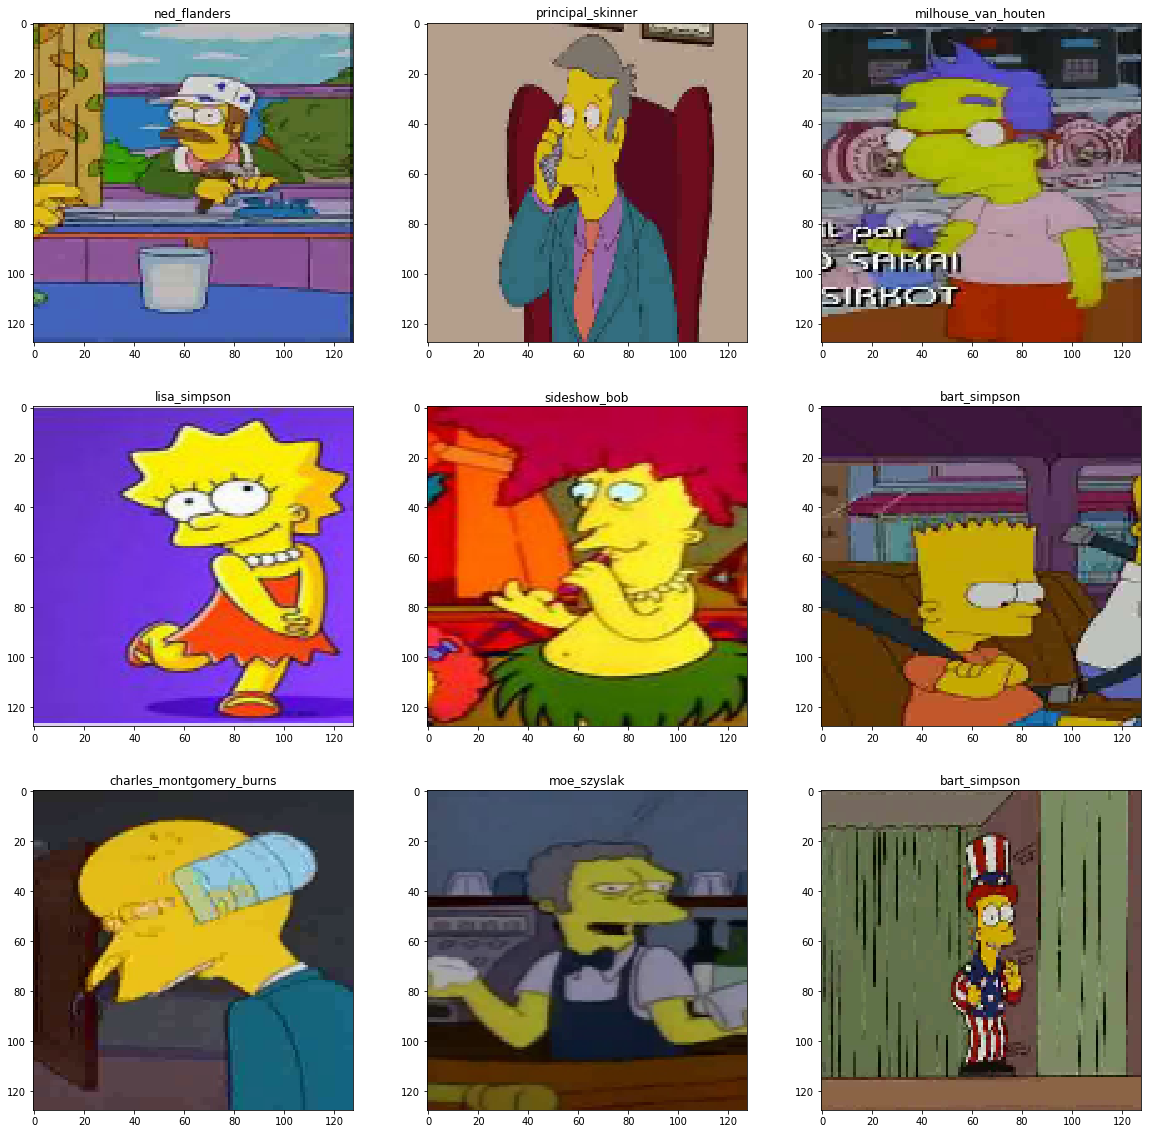

In [39]:
predict(pics_train_sm, model)

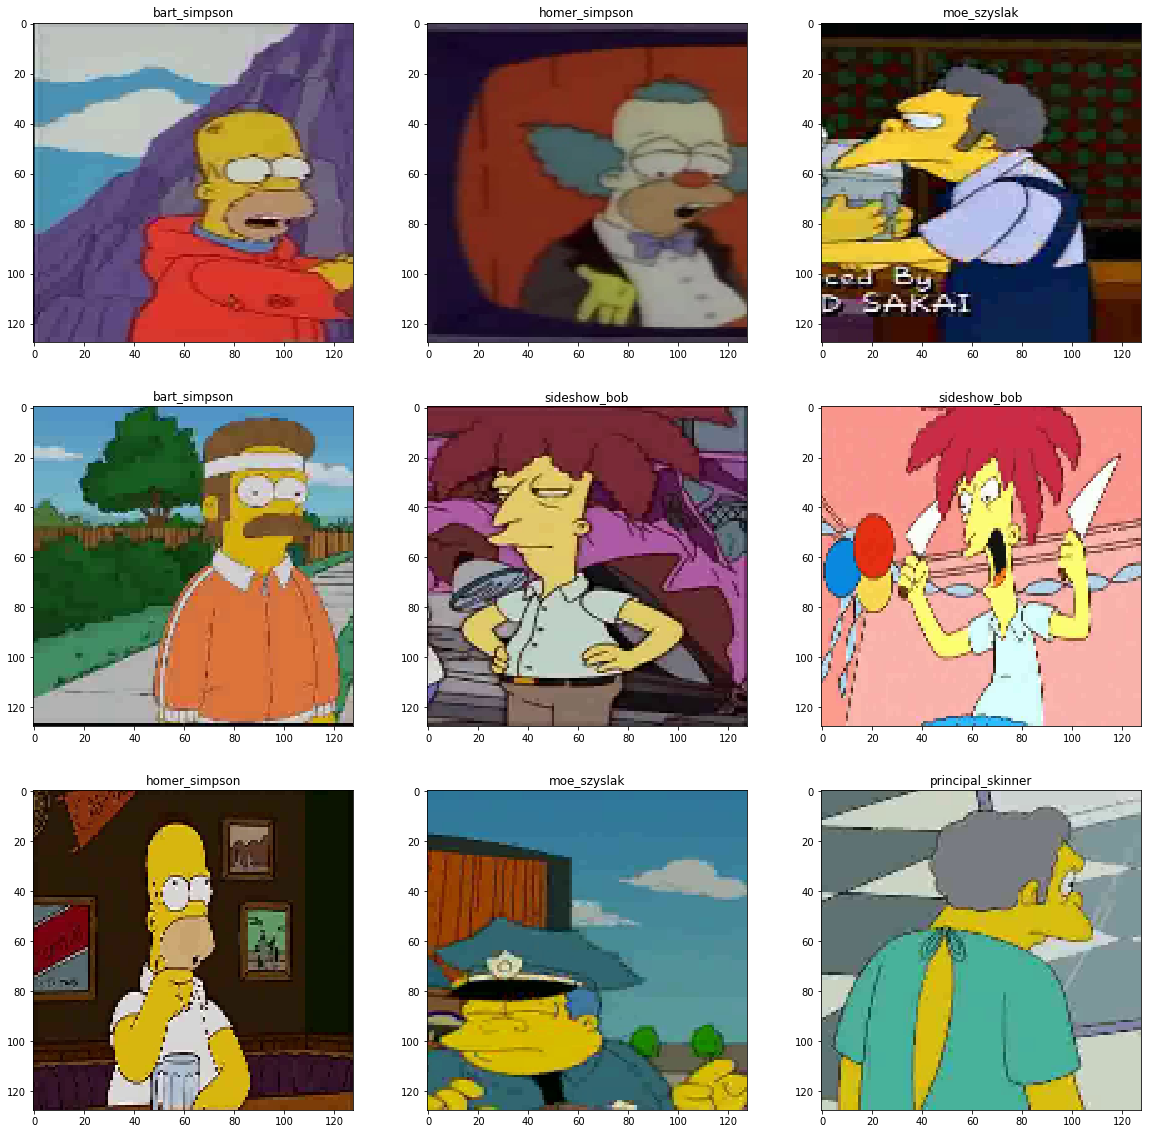

In [40]:
predict(pics_val, model)

### Training with full data

In [136]:
model = load_model()
sess = load_session()
print("Trainable parameters: {}".format(trainable_parameters()))

Trainable parameters: 2916829


In [137]:
EPOCHS = 70
BATCH_SIZE = 64
LOGS_DIR = "logs"

t_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "all-1", "train"), graph=sess.graph)
v_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "all-1", "val"), graph=sess.graph)

train(sess, model, pics_train, labels_train, pics_val, labels_val, EPOCHS, BATCH_SIZE, t_writer, v_writer, use_dropout=True)


 31%|███▏      | 22/70 [06:31<14:14, 17.81s/it]

KeyboardInterrupt: 

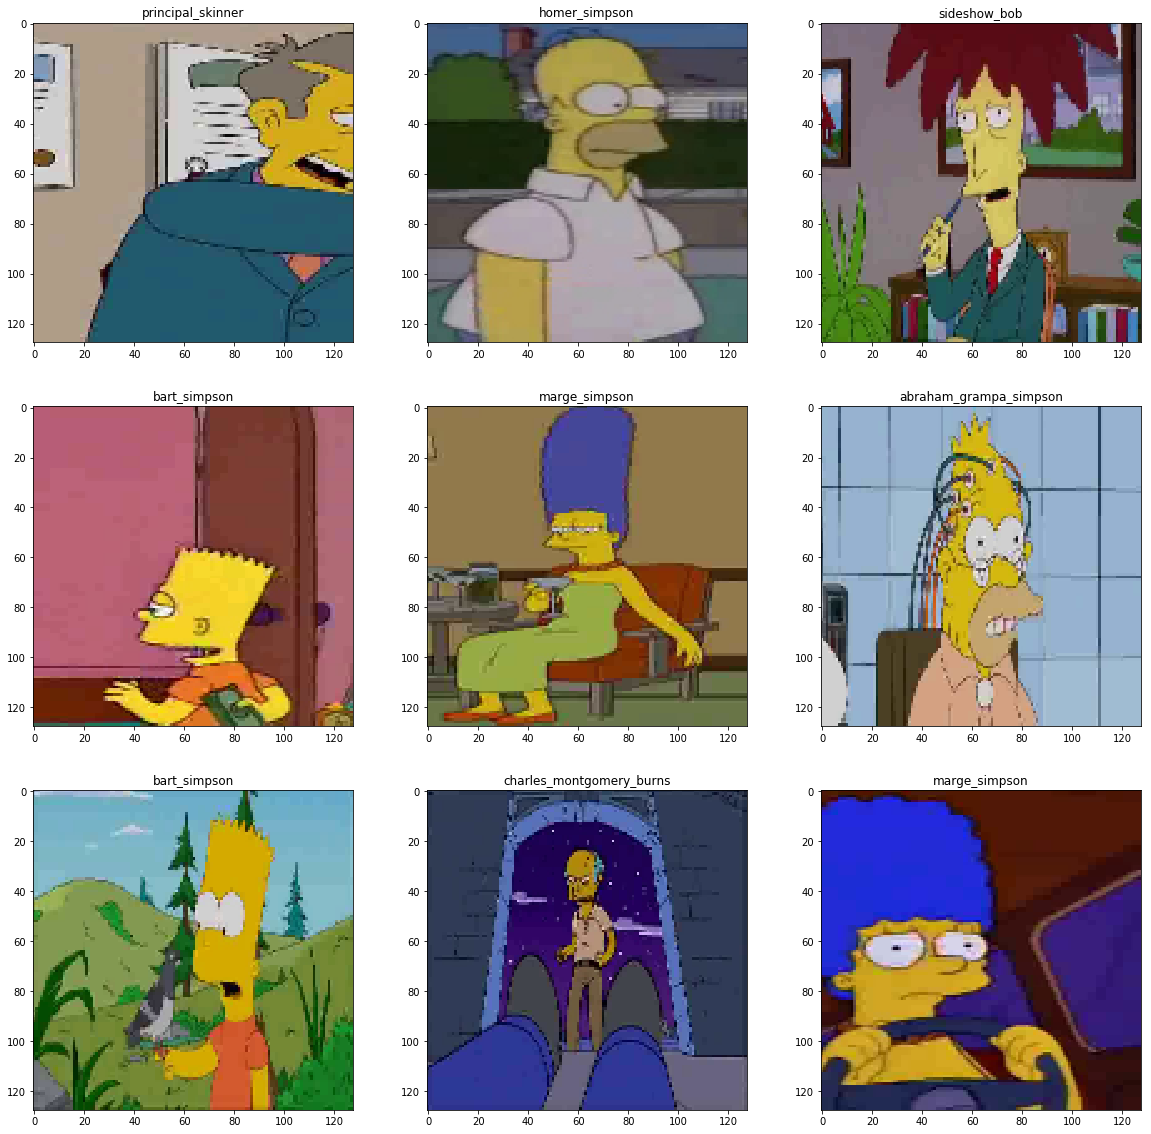

In [111]:
predict(pics_train, model)

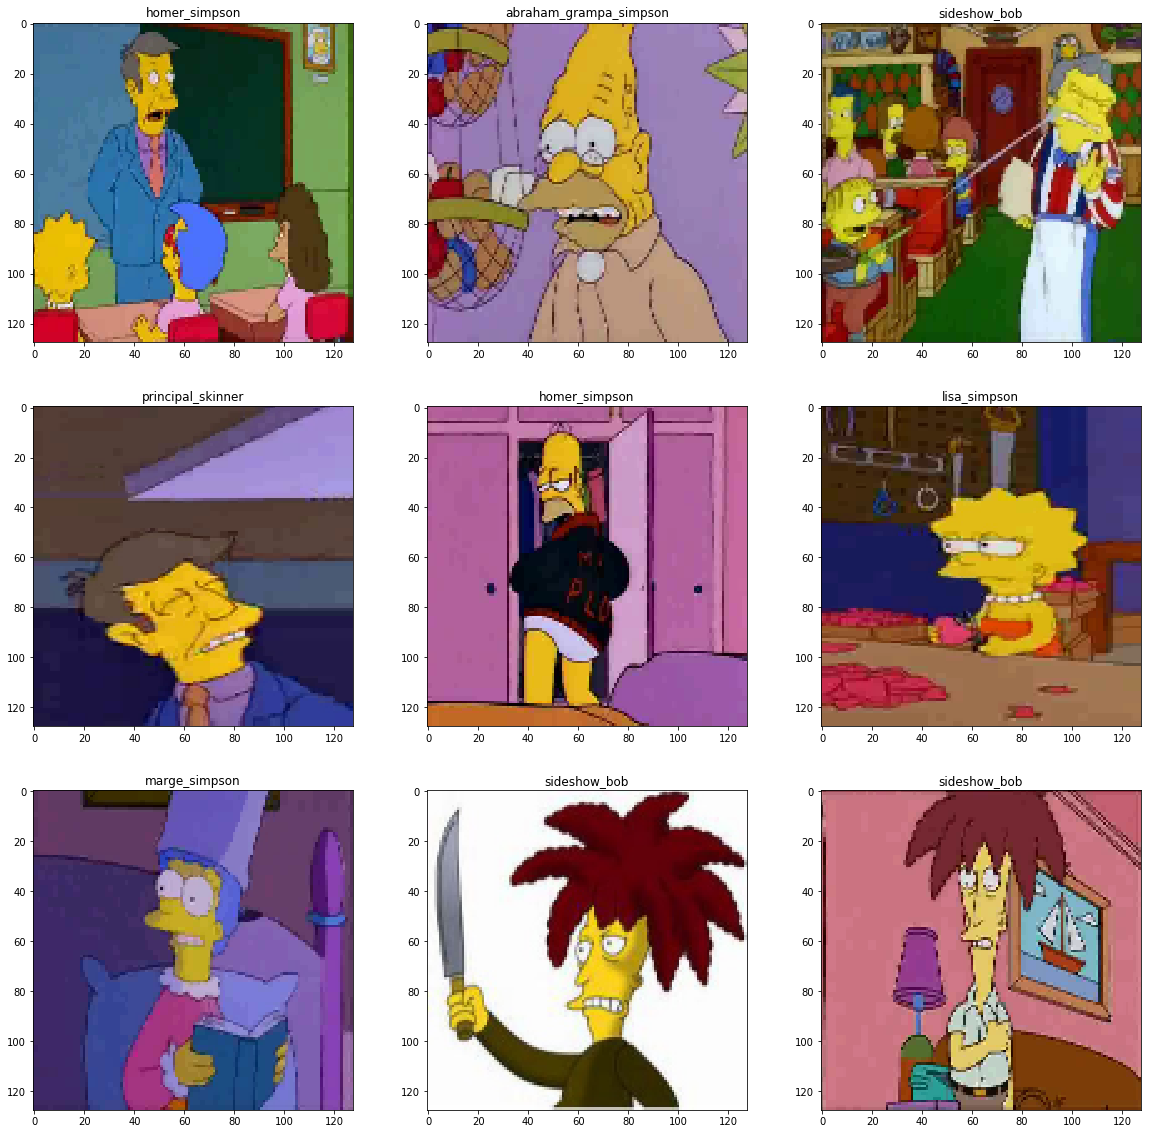

In [115]:
predict(pics_val, model)

(105, 128, 128, 3)


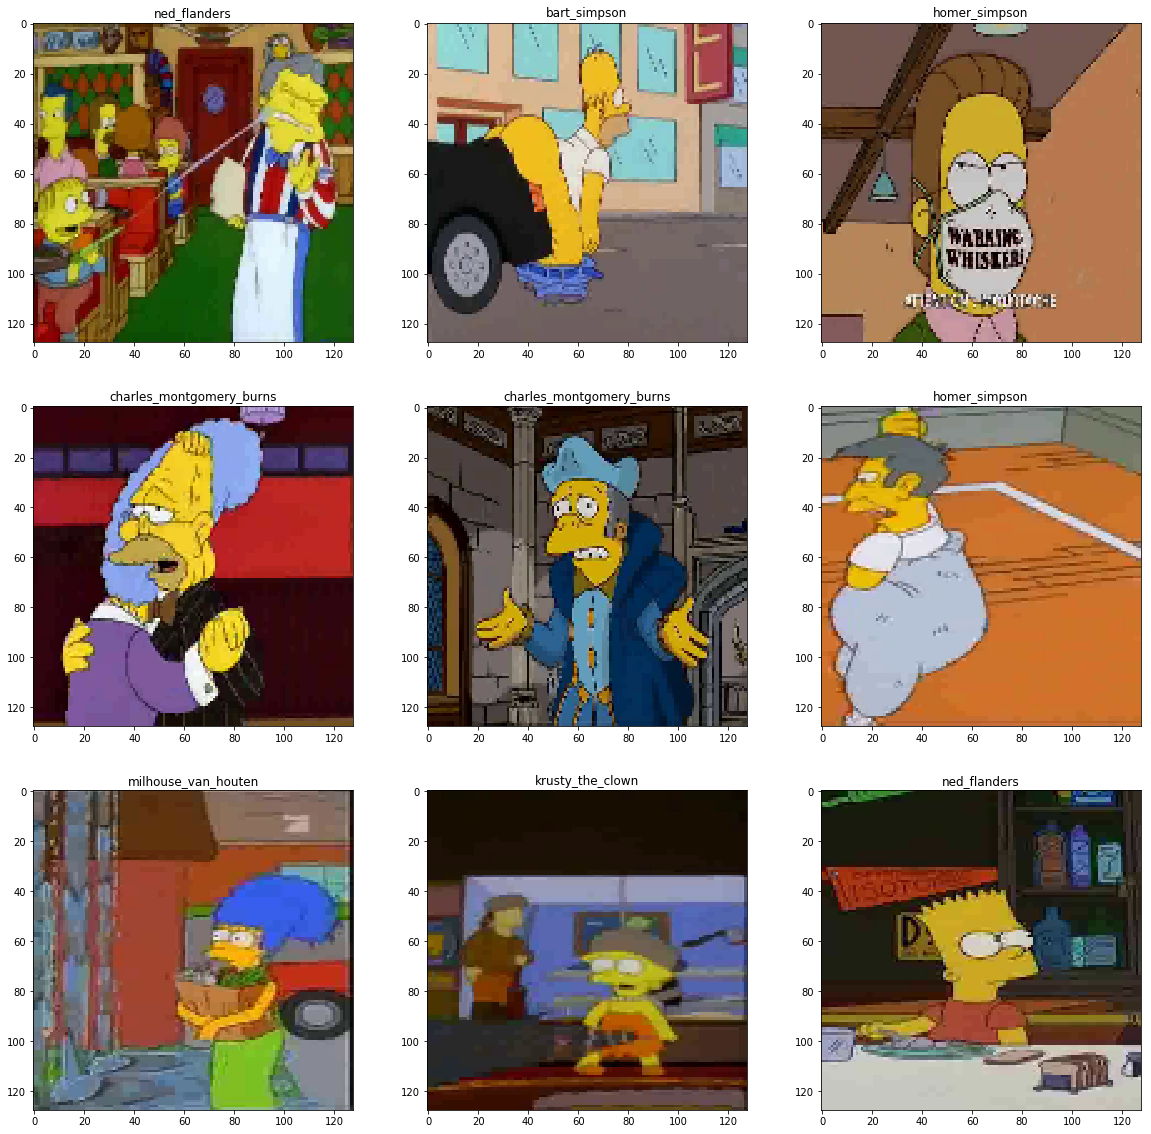

In [144]:
x, y, is_training, dropout_rate, out, loss, acc, upd, info = model

graph_out, = sess.run([out], feed_dict={x: pics_val})
pred = np.argmax(graph_out, axis=-1)
gt = np.argmax(labels_val, axis=-1)


mismatches = pics_val[pred != gt]

print(mismatches.shape)

predict(mismatches, model)